# Example notebook for pairwise registration using GreedyFHist



### Step 1: Loading image data

GreedyFHist has some utility functions for load image data, but ultimately the only requirement is that image data can be converted to a `numpy.array`.

In [1]:
import matplotlib.pyplot as plt
import pyvips
import numpy
from typing import Dict

from greedyfhist.data_types import Image, Pointset
from greedyfhist.registration import GreedyFHist, RegistrationTransforms
from greedyfhist.options import RegistrationOptions
from greedyfhist.data_types.image import read_image

In [2]:
def write_to_tiffile(img: numpy.array, 
                     path: str, 
                     metadata: Dict = None, 
                     is_annotation: bool = False,
                     tile: bool = True,
                     tile_size: int = 512,
                     pyramid: bool = True):
    if metadata is None:
        metadata = {
            'PhysicalSizeX': 1,
            'PhysicalSizeXUnit': 'px',
            'PhysicalSizeY': 1,
            'PhysicalSizeYUnit': 'px',
            'Interleaved': 'false'
        }
    # Taken from https://forum.image.sc/t/writing-qupath-bio-formats-compatible-pyramidal-image-with-libvips/51223/6
    if len(img.shape) == 3:
        w, h, c = img.shape
    else:
        c = 1
        w, h = img.shape
    if is_annotation:
        c, w, h = w, h, c
    img_vips = pyvips.Image.new_from_array(img)
    xml_string = f"""<?xml version="1.0" encoding="UTF-8"?>
    <OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
        xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
        xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
        <Image ID="Image:0">
            <!-- Minimum required fields about image dimensions -->
            <Pixels DimensionOrder="XYCZT"
                    ID="Pixels:0"
                    PhysicalSizeX="{metadata['PhysicalSizeX']}"
                    PhysicalSizeXUnit="{metadata['PhysicalSizeXUnit']}"
                    PhysicalSizeY="{metadata['PhysicalSizeY']}"
                    PhysicalSizeYUnit="{metadata['PhysicalSizeYUnit']}"
                    Interleaved="{metadata.get('Interleaved', True)}"
                    SizeC="{c}"
                    SizeT="1"
                    SizeX="{h}"
                    SizeY="{w}"
                    SizeZ="1"
                    Type="uint8">
            </Pixels>
        </Image>
        <StructuredAnnotations>
		<MapAnnotation ID="Annotation:Resolution:0" Namespace="openmicroscopy.org/PyramidResolution"><Value/></MapAnnotation></StructuredAnnotations>
    </OME>"""
    root = ET.fromstring(xml_string)
    ns = {'ns0': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}
    elem = root.find('*/ns0:Pixels', ns)
    for channel_ in metadata['channels']:
        elem.append(channel_)
    for tiff_data_ in metadata['tiff_data']:
        elem.append(tiff_data_)
    ome_metadata_xml_string = ET.tostring(root, encoding='unicode')
    img_vips.set_type(pyvips.GValue.gint_type, "page-height", img_vips.height)
    img_vips.set_type(pyvips.GValue.gstr_type, "image-description", ome_metadata_xml_string)
    img_vips.tiffsave(path, tile=tile, tile_width=tile_size, tile_height=tile_size, pyramid=pyramid)
    return ome_metadata_xml_string
    

In [2]:
path_to_moving_image = '../pairwise_examples/images/moving_image.ome.tif'
path_to_fixed_image = '../pairwise_examples/images/fixed_image.ome.tif'

moving_image = OMETIFFImage.load_from_path(path_to_moving_image)
fixed_image = OMETIFFImage.load_from_path(path_to_fixed_image)

Text(0.5, 1.0, 'Fixed Image')

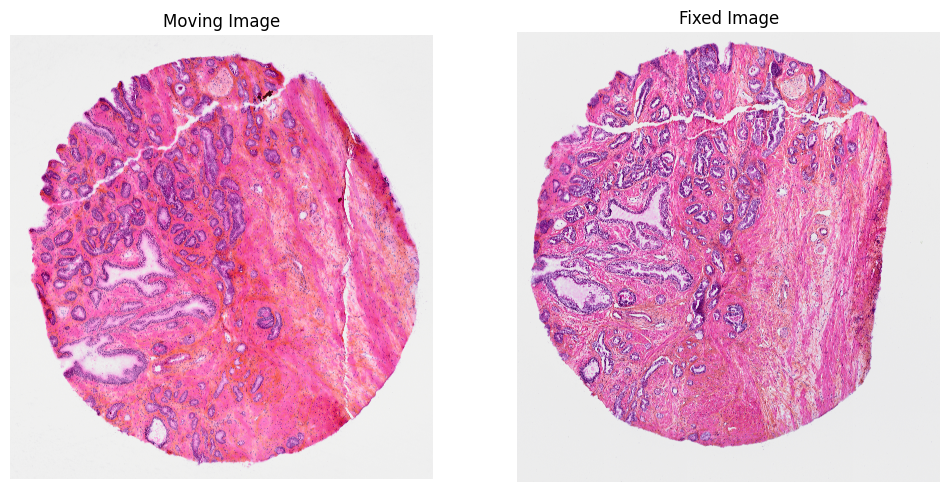

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')

### Step 2: Setting registration options and performing registration.

In [4]:
# Default options do not need to be parsed
options = RegistrationOptions()
# options.compute_reverse_nonrigid_registration = True
# options.nonrigid_registration_options.resolution = (2048, 2048)
options.do_affine_registration = False
# options.do_nonrigid_registration = False
options.affine_registration_options.n_threads = 8
options.nonrigid_registration_options.n_threads = 8
# options.do_nonrigid_registration = False
# For large images we recommend to use downscaling.
options.pre_sampling_factor = 0.25
options.remove_temporary_directory = False
options.compute_reverse_nonrigid_registration = True

# init registerer
registerer = GreedyFHist.load_from_config()

# registration_result, reverse_registration_result = registerer.register(moving_img=moving_image.data,
#                                           fixed_img=fixed_image.data,
#                                           options=options
#                                           )

aff_registration_result = registerer.register(moving_img=moving_image.data,
                                          fixed_img=fixed_image.data,
                                          options=options
                                          )

A registration result consists of 2 transformations: A forward transformation from moving to fixed image space and a backward transformatino from fixed to moving image space. Internally transformations are executed using SimpleITK. Forward transformations are used to transform image data, backward transformations are used for pointset valued data.

In [5]:
# warped_moving_image = registerer.transform_image(moving_image.data, registration_result.forward_transform, 'LINEAR')
# warped_fixed_image = registerer.transform_image(fixed_image.data, reverse_registration_result.forward_transform, 'LINEAR')

warped_moving_image = registerer.transform_image(moving_image.data, aff_registration_result.registration_transform.forward_transform, 'LINEAR')
warped_fixed_image = registerer.transform_image(fixed_image.data, aff_registration_result.reverse_registration_transform.forward_transform, 'LINEAR')

Text(0.5, 1.0, 'Transformed Image')

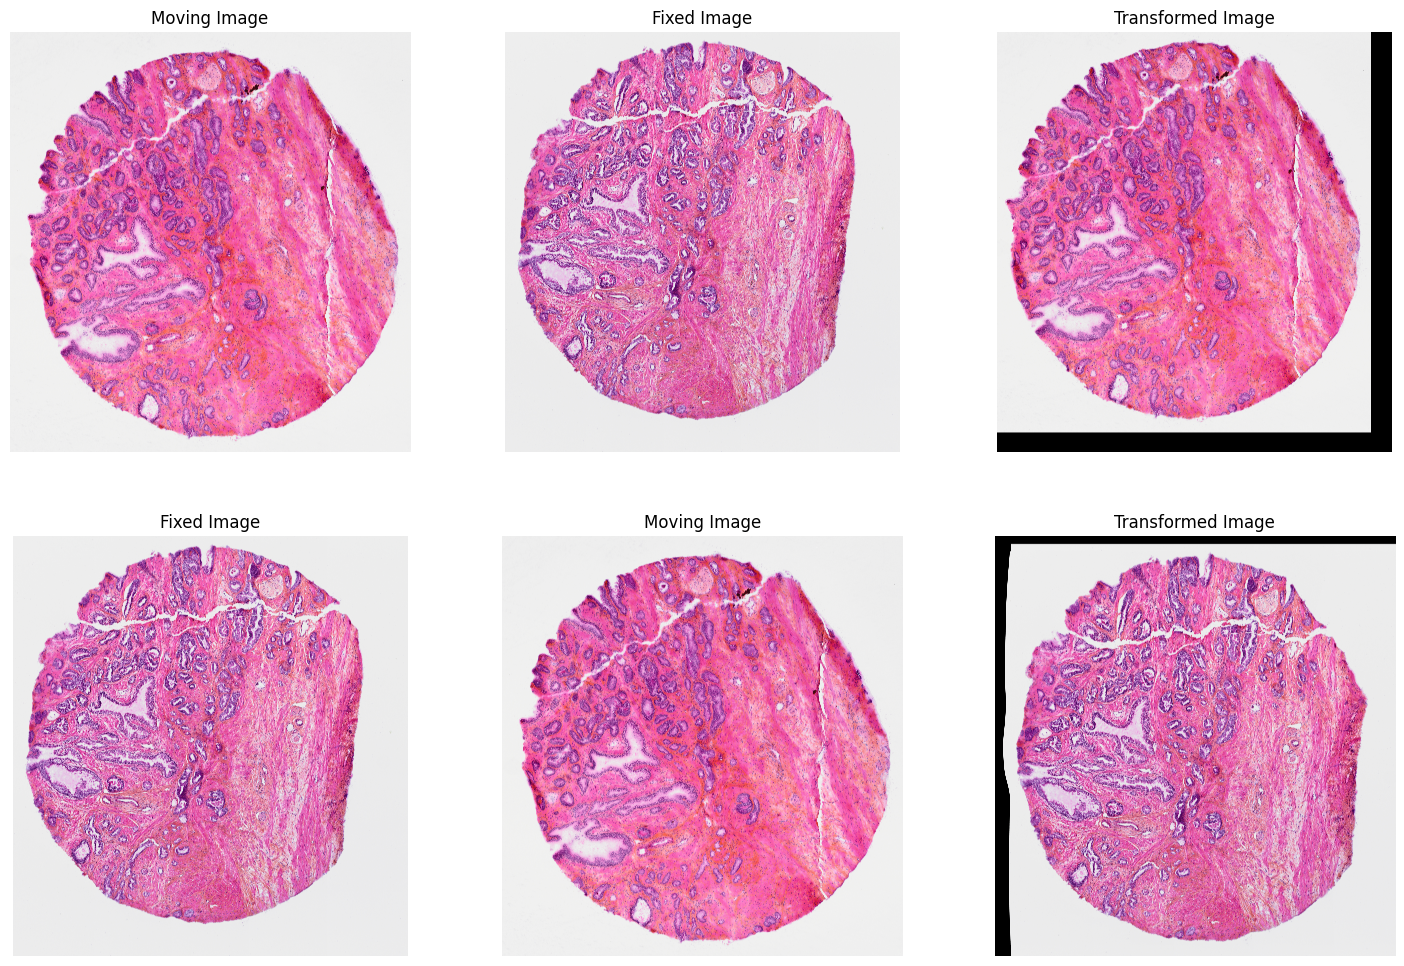

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i,j].axis('off')
axs[0, 0].imshow(moving_image.data)
axs[0, 0].set_title('Moving Image')
axs[0, 1].imshow(fixed_image.data)
axs[0, 1].set_title('Fixed Image')
axs[0, 2].imshow(warped_moving_image)
axs[0, 2].set_title('Transformed Image')
axs[1, 0].imshow(fixed_image.data)
axs[1, 0].set_title('Fixed Image')
axs[1, 1].imshow(moving_image.data)
axs[1, 1].set_title('Moving Image')
axs[1, 2].imshow(warped_fixed_image)
axs[1, 2].set_title('Transformed Image')

In [11]:
a = [1,2,3]
list(range(2,0, -1))

[2, 1]

In [14]:
a[:-2]

[1]

In [10]:
ft_nr = registration_result.forward_transform.transform
print(ft_nr.GetNthTransform(3).GetNthTransform(0).GetTranslation())
print(ft_nr.GetNthTransform(3).GetNthTransform(0).GetMatrix())

(-518.2863271484375, 732.9524521484375)
(0.905118, 0.428767, -0.421906, 0.907913)


In [11]:
ftr_nr = reverse_registration_result.forward_transform.transform
print(ftr_nr.GetNthTransform(3).GetNthTransform(0).GetTranslation())
print(ftr_nr.GetNthTransform(3).GetNthTransform(0).GetMatrix())

(782.7365581505638, -443.5570388851859)
(0.9054973425894586, -0.42762619225636644, 0.42078344711723253, 0.9027097791637364)


In [12]:
registration_result, reverse_registration_result

(RegistrationResult(forward_transform=GFHTransform(size=(11915, 11198), transform=<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7fc9c0575270> >), backward_transform=GFHTransform(size=(11581, 11033), transform=<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7fc9c05757b0> >), cmdln_returns=[CompletedProcess(args=['greedy', '-d', '2', '-i', 'tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz', 'tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz', '-o', 'tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat', '-m', 'ncc', '10x10', '-n', '100x50x10', '-threads', '8', '-dof', '12', '-search', '10000', '180', '106', '-gm-trim', '10x10', '-a', '-ia', 'tmp/0/Affine_init.mat'], returncode=0, stdout=b'Limiting the number of threads to 8\nNoise on image 0 component 0: fixed = 0.218694, moving = 0.219887\nRigid search

In [18]:
ft_a = aff_registration_result.forward_transform.transform
ftr_a = aff_reverse_registration_result.forward_transform.transform

In [19]:
aff_registration_result, aff_reverse_registration_result

(RegistrationResult(forward_transform=GFHTransform(size=(11915, 11198), transform=<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7fc9c0575030> >), backward_transform=GFHTransform(size=(11581, 11033), transform=<SimpleITK.SimpleITK.CompositeTransform; proxy of <Swig Object of type 'itk::simple::CompositeTransform *' at 0x7fca32564c60> >), cmdln_returns=[CompletedProcess(args=['greedy', '-d', '2', '-i', 'tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz', 'tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz', '-o', 'tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat', '-m', 'ncc', '10x10', '-n', '100x50x10', '-threads', '8', '-dof', '12', '-search', '10000', '180', '106', '-gm-trim', '10x10', '-a', '-ia', 'tmp/0/Affine_init.mat'], returncode=0, stdout=b'Limiting the number of threads to 8\nNoise on image 0 component 0: fixed = 0.218694, moving = 0.219887\nRigid search

In [7]:
options.affine_registration_options.resolution
options.nonrigid_registration_options.resolution

(1024, 1024)

In [32]:
ft = registration_result.forward_transform.transform
print(ft.GetNthTransform(3).GetTranslation())
print(ft.GetNthTransform(3).GetMatrix())

(-518.2863271484375, 732.9524521484375)
(0.905118, 0.428767, -0.421906, 0.907913)


In [ ]:
(-518.2863271484375, 732.9524521484375)
(0.905118, 0.428767, -0.421906, 0.907913)

In [33]:
ft = reverse_registration_result.forward_transform.transform
print(ft.GetNthTransform(3).GetTranslation())
print(ft.GetNthTransform(3).GetMatrix())

(782.7365581505638, -443.5570388851859)
(0.9054973425894586, -0.42762619225636644, 0.42078344711723253, 0.9027097791637364)


In [30]:
(782.736558150564, -443.5570388851859)
(0.9054973425894586, -0.42762619225636644, 0.42078344711723253, 0.9027097791637364)

NameError: name 'asldkalksdalsk' is not defined

In [48]:
# Aff registration
ft_a = registration_result.forward_transform.transform
ftr_a = reverse_registration_result.forward_transform.transform

In [62]:
ftr_a.GetNthTransform(3)

<SimpleITK.SimpleITK.AffineTransform; proxy of <Swig Object of type 'itk::simple::AffineTransform *' at 0x7fd5338ae750> >

In [20]:
ftr_a.GetNthTransform(0).GetScale()
ftr_a.GetNthTransform(1).GetOffset()
# ftr_a.GetNthTransform(2).GetOffset()
# print(ftr_a.GetNthTransform(3).GetTranslation())
# print(ftr_a.GetNthTransform(3).GetMatrix())

(-159.0, -7.0)

In [21]:
ftr_nr.GetNthTransform(0).GetScale()
ftr_nr.GetNthTransform(1).GetOffset()
# ftr_nr.GetNthTransform(2).GetOffset()
# print(ftr_nr.GetNthTransform(3).GetNthTransform(0).GetTranslation())
# print(ftr_nr.GetNthTransform(3).GetNthTransform(0).GetMatrix())

(-159.0, -7.0)

In [24]:
reverse_registration_result.reg_params.moving_preprocessing_params

{'resampling_factor': 0.25,
 'original_image_size': (11915, 11198),
 'cropping_params': (58, 2756, 90, 2485),
 'original_shape_image': (2978, 2799, 3),
 'padding': (159, 159, 7, 8),
 'cropped_padded_mask': (7, 2704, 159, 2553)}

In [26]:
reverse_registration_result.reg_params.fixed_preprocessing_params

{'resampling_factor': 0.25,
 'original_image_size': (11581, 11033),
 'cropping_params': (106, 2819, 119, 2673),
 'original_shape_image': (2895, 2758, 3),
 'padding': (79, 80, 0, 0),
 'cropped_padded_mask': (0, 2712, 79, 2632)}

In [25]:
aff_reverse_registration_result.reg_params.moving_preprocessing_params

{'resampling_factor': 0.25,
 'original_image_size': (11581, 11033),
 'cropping_params': (106, 2819, 119, 2673),
 'original_shape_image': (2895, 2758, 3),
 'padding': (79, 80, 0, 0),
 'cropped_padded_mask': (0, 2712, 79, 2632)}

In [70]:
ft_nr.GetNthTransform(3).GetNthTransform(0)

<SimpleITK.SimpleITK.AffineTransform; proxy of <Swig Object of type 'itk::simple::AffineTransform *' at 0x7fd533487510> >

In [42]:
# NR registration

In [26]:
aff_trans = sitk.AffineTransform(2)
aff_trans.SetTranslation((-518.2863271484375, 732.9524521484375))
aff_trans.SetMatrix((0.905118, 0.428767, -0.421906, 0.907913))
print(aff_trans.GetInverse().GetTranslation())
print(aff_trans.GetInverse().GetMatrix())

(782.736558150564, -443.5570388851859)
(0.9054973425894586, -0.42762619225636644, 0.42078344711723253, 0.9027097791637364)


In [8]:
from greedyfhist.utils.image import read_affine_transform
import SimpleITK as sitk
import numpy as np

a = read_affine_transform('tmp/0/output/registrations/0/metrics/small_resolution/small_affine.mat')
b = read_affine_transform('tmp/0/output/registrations_rev/0/metrics_rev/small_resolution/small_affine.mat')

img1 = sitk.GetArrayFromImage(sitk.ReadImage('tmp/0/affine_moving_preprocessing/preprocessed/new_small_image.nii.gz'))
img2 = sitk.GetArrayFromImage(sitk.ReadImage('tmp/0/affine_fixed_preprocessing/preprocessed/new_small_image.nii.gz'))


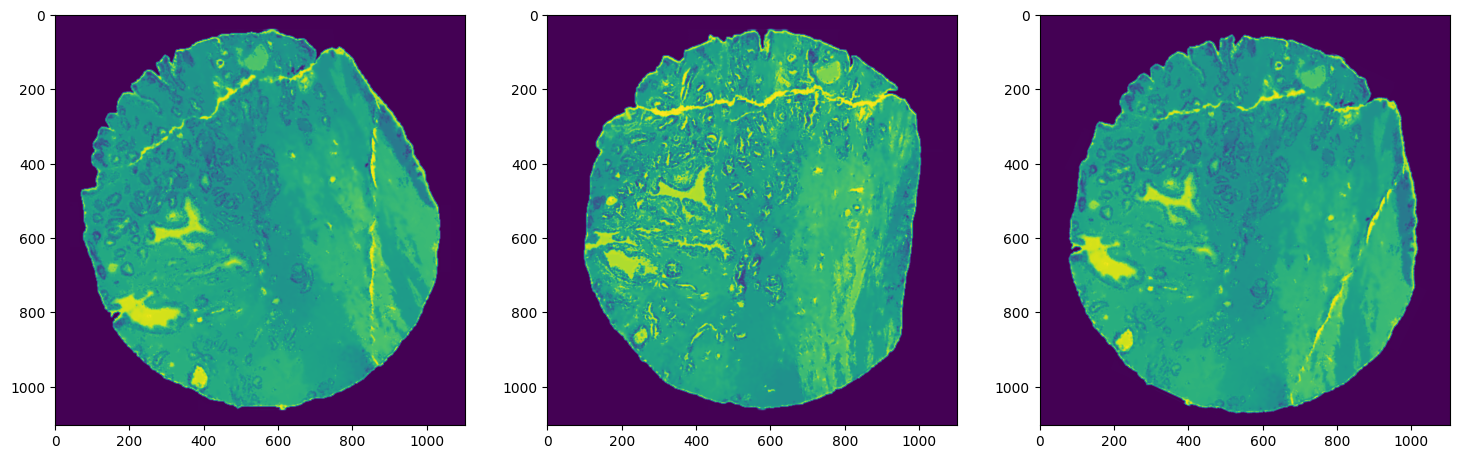

In [9]:
interpolator = sitk.sitkLinear
ref_img = sitk.GetImageFromArray(np.zeros(img2.shape), True)
sitk_image = sitk.GetImageFromArray(img1, True)
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(ref_img)
resampler.SetInterpolator(interpolator)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(a)
warped_image_sitk = resampler.Execute(sitk_image)
img3 = sitk.GetArrayFromImage(warped_image_sitk)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)

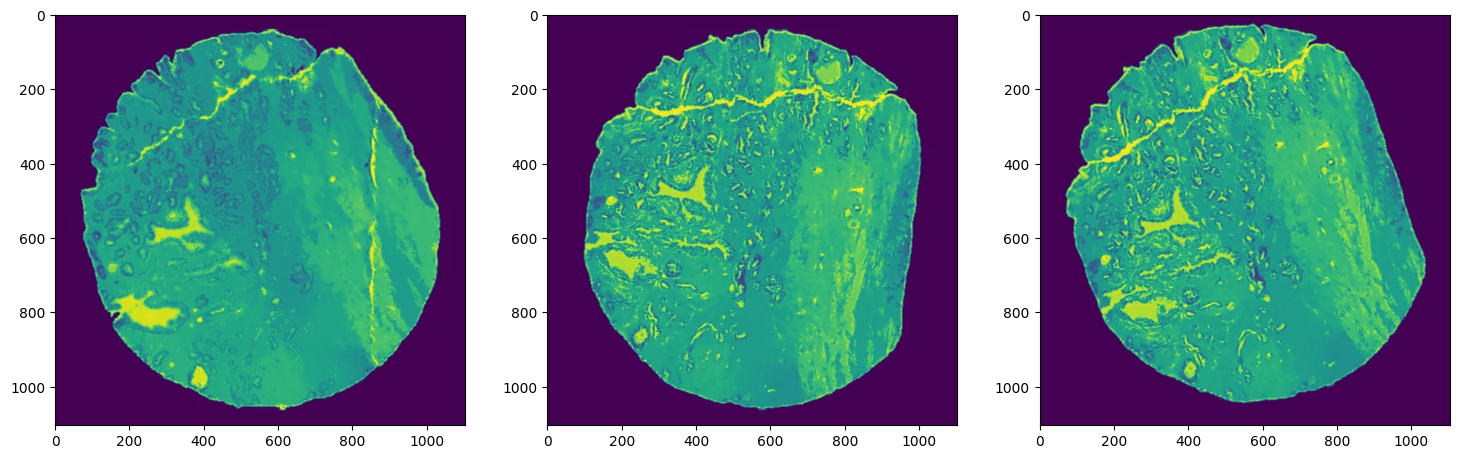

In [10]:
interpolator = sitk.sitkLinear
ref_img = sitk.GetImageFromArray(np.zeros(img1.shape), True)
sitk_image = sitk.GetImageFromArray(img2, True)
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(ref_img)
resampler.SetInterpolator(interpolator)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(b)
warped_image_sitk = resampler.Execute(sitk_image)
img3 = sitk.GetArrayFromImage(warped_image_sitk)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)

Text(0.5, 1.0, 'Transformed Image')

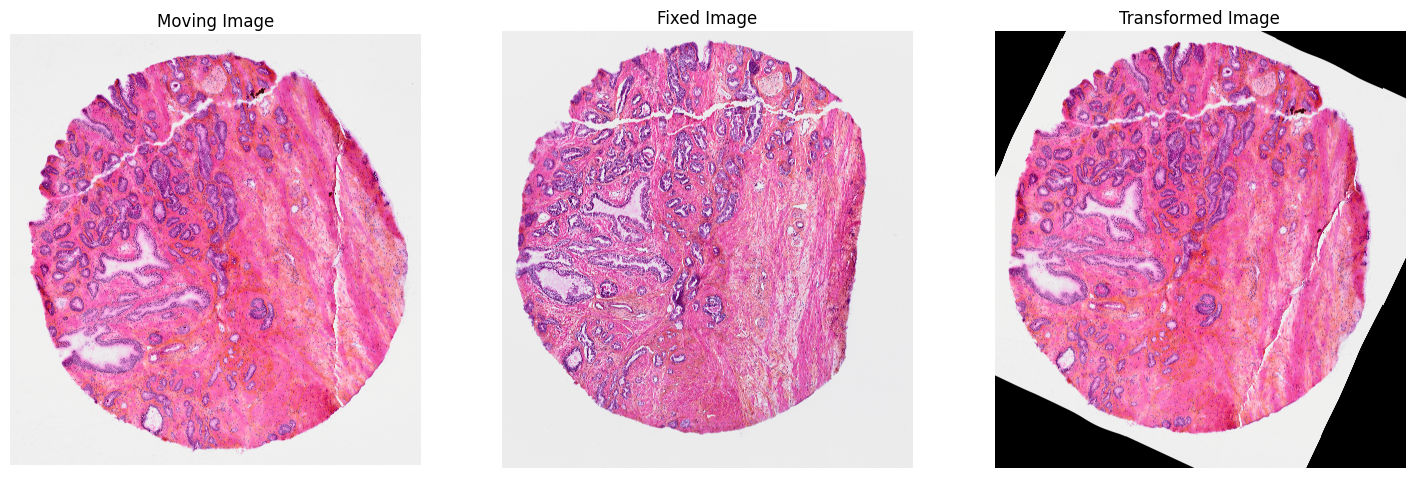

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')
axs[2].imshow(warped_moving_image)
axs[2].set_title('Transformed Image')


### Step 3: Saving and loading transformation data

Transformations can be stored and loaded at a later point.

In [9]:
registration_result.to_file('saved_transform')
loaded_reg_result = RegistrationTransforms.load('saved_transform')

In [11]:
warped_image2 = registerer.transform_image(moving_image.data, loaded_reg_result.forward_transform, 'LINEAR')

In [14]:
ps  = Pointset.load_from_path('../pairwise_examples/annotations/moving_pointset.csv')
warped_ps = registerer.transform_pointset(ps.to_numpy(), loaded_reg_result.backward_transform)

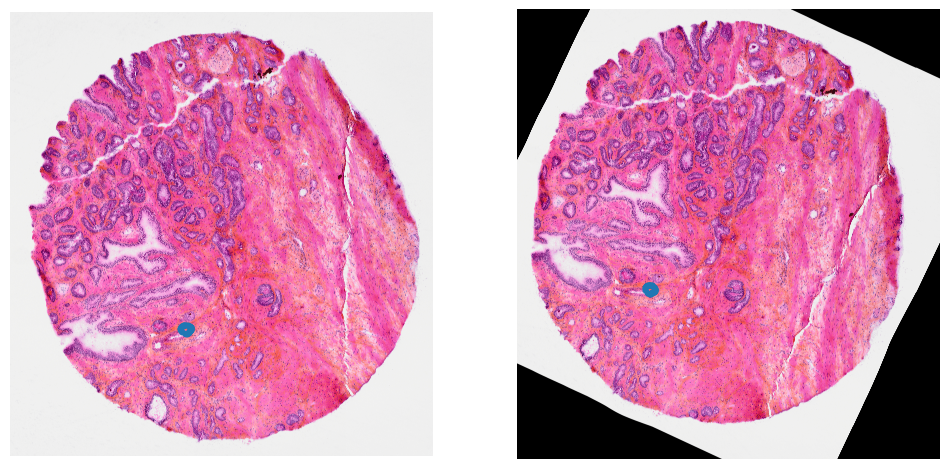

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12 ,6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
ps_np = ps.to_numpy()
axs[0].plot(ps_np[:, 0], ps_np[:, 1], '.')
axs[1].imshow(warped_image2)
axs[1].plot(warped_ps[:, 0], warped_ps[:, 1], '.')